# Projeto Spotify - #7DaysOfCode

O objetivo deste projeto é analisar dados do Spotify e aplicar técnicas de Machine Learning para prever a popularidade das músicas.
 
Para isso, é desenvolvido um modelo de classificação para prever se uma música será popular ou não, utilizando técnicas de distribuição para lidar com o desbalanceamento dos dados.
 
Foi utilizado este [dataset do Kaggle.](https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset?resource=download)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='white')

# evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix, auc, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# resampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from collections import Counter

# hiperparameters
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## Carregar a base de dados

In [2]:
# import dataset
df_spotify = pd.read_csv('dataset.csv', index_col=0)
print(df_spotify.shape)
display(df_spotify.head())

(114000, 20)


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


## Limpar base

Vamos excluir colunas desnecessárias, identificar valores faltantes(NA), linhas duplicadas e outras inconsistênsias na base de dados.

#### Tratar valores ausentes (NAs)

In [3]:
df_spotify.isnull().sum()

track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

In [4]:
# remove NAs rows
df_spotify = df_spotify.dropna(axis=0,how='any')
print(df_spotify.shape)

(113999, 20)


#### Verificar se há registros duplicados

Aparecem registros diplicados. Note que a 'track_id' das musicas duplicadas é identica. 

Vamos excluir essas duplicatas.

In [5]:
print('Duplicated rows: {}'.format(df_spotify.duplicated().sum()))
df_spotify[df_spotify.duplicated(keep=False)].head(4)

Duplicated rows: 450


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
1874,0CDucx9lKxuCZplLXUz0iX,Buena Onda Reggae Club,Disco 2,Song for Rollins,16,219346,False,0.841,0.577,0,-7.544,1,0.0438,0.238,0.860000,0.0571,0.843,90.522,4,afrobeat
1925,0CDucx9lKxuCZplLXUz0iX,Buena Onda Reggae Club,Disco 2,Song for Rollins,16,219346,False,0.841,0.577,0,-7.544,1,0.0438,0.238,0.860000,0.0571,0.843,90.522,4,afrobeat
2109,2aibwv5hGXSgw7Yru8IYTO,Red Hot Chili Peppers,Stadium Arcadium,Snow (Hey Oh),80,334666,False,0.427,0.900,11,-3.674,1,0.0499,0.116,0.000017,0.1190,0.599,104.655,4,alt-rock
2155,2aibwv5hGXSgw7Yru8IYTO,Red Hot Chili Peppers,Stadium Arcadium,Snow (Hey Oh),80,334666,False,0.427,0.900,11,-3.674,1,0.0499,0.116,0.000017,0.1190,0.599,104.655,4,alt-rock


In [6]:
# drop diplicates
linhas_antes_exc_dupl = df_spotify.shape[0]
df_spotify = df_spotify.drop_duplicates()
linhas_depois_exc_dupl = df_spotify.shape[0]

print('Rows droped: {}'.format(linhas_antes_exc_dupl-linhas_depois_exc_dupl))

Rows droped: 450


Se desconsiderarmos a coluna 'track_id', vemos que existem 127 duplicatas na base.

Nesse caso, vamos aceitar a hipótese de que a track id define a identidade de cada música e manter essas linhas.

In [7]:
print(df_spotify.duplicated().sum())
print(df_spotify.drop('track_id',axis=1).duplicated().sum())

df_spotify.drop('track_id',axis=1)[df_spotify.drop('track_id',axis=1).duplicated()]

0
127


,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
2046,The Killers;Ryan Pardey,Alternative Christmas 2022,Don't Shoot Me Santa,0,245106,False,0.588,0.847,8,-4.164,1,0.0705,0.06010,0.000000,0.3070,0.662,120.041,4,alt-rock
2085,The Smashing Pumpkins,Alternative Christmas 2022,Christmastime,0,196723,False,0.165,0.434,0,-8.163,1,0.0288,0.31600,0.171000,0.2130,0.186,77.983,3,alt-rock
2094,Weezer,Alternative Christmas 2022,We Wish You A Merry Christmas,0,84973,False,0.387,0.786,11,-4.127,1,0.0436,0.01950,0.000000,0.1230,0.462,149.806,3,alt-rock
2168,Counting Crows,Alternative Christmas 2022,A Long December,0,297293,False,0.403,0.590,5,-5.941,1,0.0284,0.50800,0.005480,0.2720,0.393,141.649,4,alt-rock
2231,Jimmy Eat World,Alternative Christmas 2022,Last Christmas,0,267493,False,0.532,0.842,2,-6.152,1,0.0403,0.00131,0.000001,0.3300,0.715,126.042,4,alt-rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103177,Surfaces,Best Road Trip Pop Tunes,Next Thing (Loverboy),0,183109,False,0.719,0.415,2,-8.983,1,0.0902,0.55800,0.000000,0.2930,0.463,160.020,4,soul
103599,The Supremes,Best R&B Tunes,If My Friends Could See Me Now/Nothing Can Sto...,0,198965,False,0.300,0.579,0,-9.583,0,0.0391,0.54000,0.000073,0.9810,0.707,77.150,4,soul
103888,Greentea Peng,Best R&B Tunes,Sinner,0,140466,False,0.690,0.390,4,-10.636,0,0.0429,0.28200,0.027700,0.1040,0.136,118.085,4,soul
107921,Little Jinder;First Aid Kit,Hejdå,Goldwing (feat. First Aid Kit),23,208828,False,0.540,0.770,2,-5.597,1,0.0279,0.03940,0.000005,0.0904,0.187,133.942,4,synth-pop


#### Verificar tipos de dados em cada coluna

A princípio o tipo de cada coluna está ok. Vamos fazer outras modificações detalhadas na seção de pré-processamento.

In [8]:
print(df_spotify.dtypes)
display(df_spotify[0:2].T)

track_id             object
artists              object
album_name           object
track_name           object
popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object


,0,1
track_id,5SuOikwiRyPMVoIQDJUgSV,4qPNDBW1i3p13qLCt0Ki3A
artists,Gen Hoshino,Ben Woodward
album_name,Comedy,Ghost (Acoustic)
track_name,Comedy,Ghost - Acoustic
popularity,73,55
duration_ms,230666,149610
explicit,False,False
danceability,0.676,0.42
energy,0.461,0.166
key,1,1


## Análise exploratória e descritiva

A análise exploratória pode ajudar a identificar padrões, tendências e relações entre as variáveis. Isso pode fornecer insights sobre o que torna uma música popular no Spotify.

perguntas que os dados podem responder:
- Quais são as 100 músicas mais populares? 
- Quais os artistas mais populares? 
- Dentre os gêneros musicais, quais são mais populares?

In [9]:
# data for analysis
df_spotify_analise = df_spotify.loc[:,['artists','album_name','track_name','track_genre','popularity']]
df_spotify_analise['track_name_artist'] = df_spotify_analise.loc[:,'track_name'] + ' - ' + df_spotify_analise.loc[:,'artists'] 
df_spotify_analise['album_name_artist'] = df_spotify_analise.loc[:,'album_name'] + ' - ' + df_spotify_analise.loc[:,'artists']

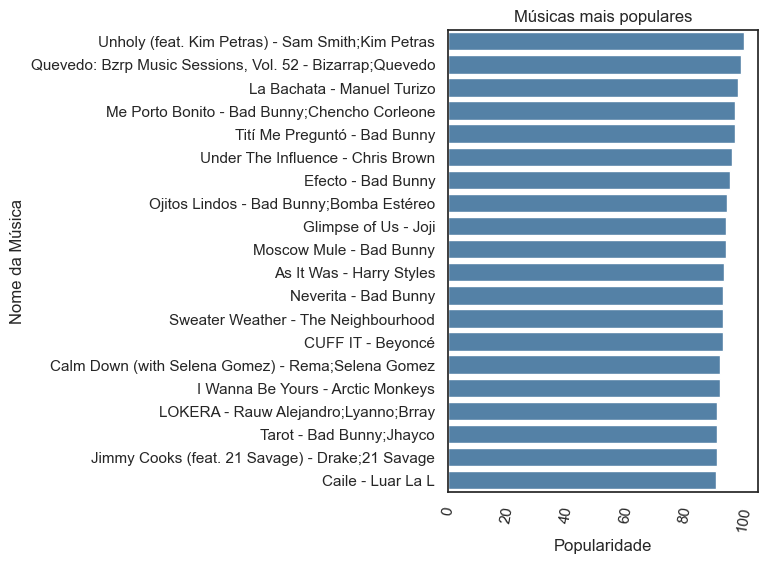

In [10]:
# most popular songs
df_top20musics = df_spotify_analise.groupby('track_name_artist')['popularity'].mean().reset_index().sort_values(by='popularity',ascending=False).head(20)

plt.figure(figsize=(4,6))
sns.barplot(data=df_top20musics,
           y = 'track_name_artist',
           x = 'popularity',
           color='steelblue').set(title='Músicas mais populares')
plt.xlabel("Popularidade")
plt.ylabel("Nome da Música")
plt.xticks(rotation=80)
plt.show()

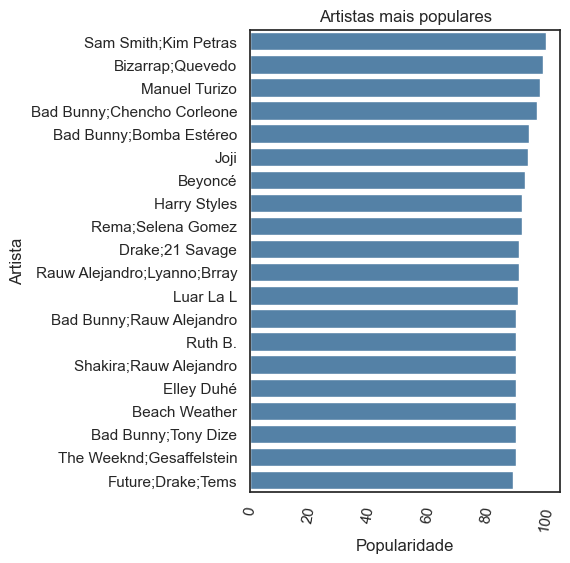

In [11]:
# most popular artists
df_top20srtists = df_spotify_analise.groupby('artists')['popularity'].mean().reset_index().sort_values(by='popularity',ascending=False).head(20)

plt.figure(figsize=(4,6))
sns.barplot(data=df_top20srtists,
           y = 'artists',
           x = 'popularity',
           color='steelblue').set(title='Artistas mais populares')
plt.xlabel("Popularidade")
plt.ylabel("Artista")
plt.xticks(rotation=80)
plt.show()

In [12]:
# most popular music genres
df_top20genres = df_spotify_analise.groupby('track_genre')['popularity'].mean().sort_values(ascending=False).head(20)
display(df_top20genres.reset_index()[['track_genre']])

,track_genre
0,pop-film
1,k-pop
2,chill
3,sad
4,grunge
5,indian
6,anime
7,emo
8,pop
9,sertanejo


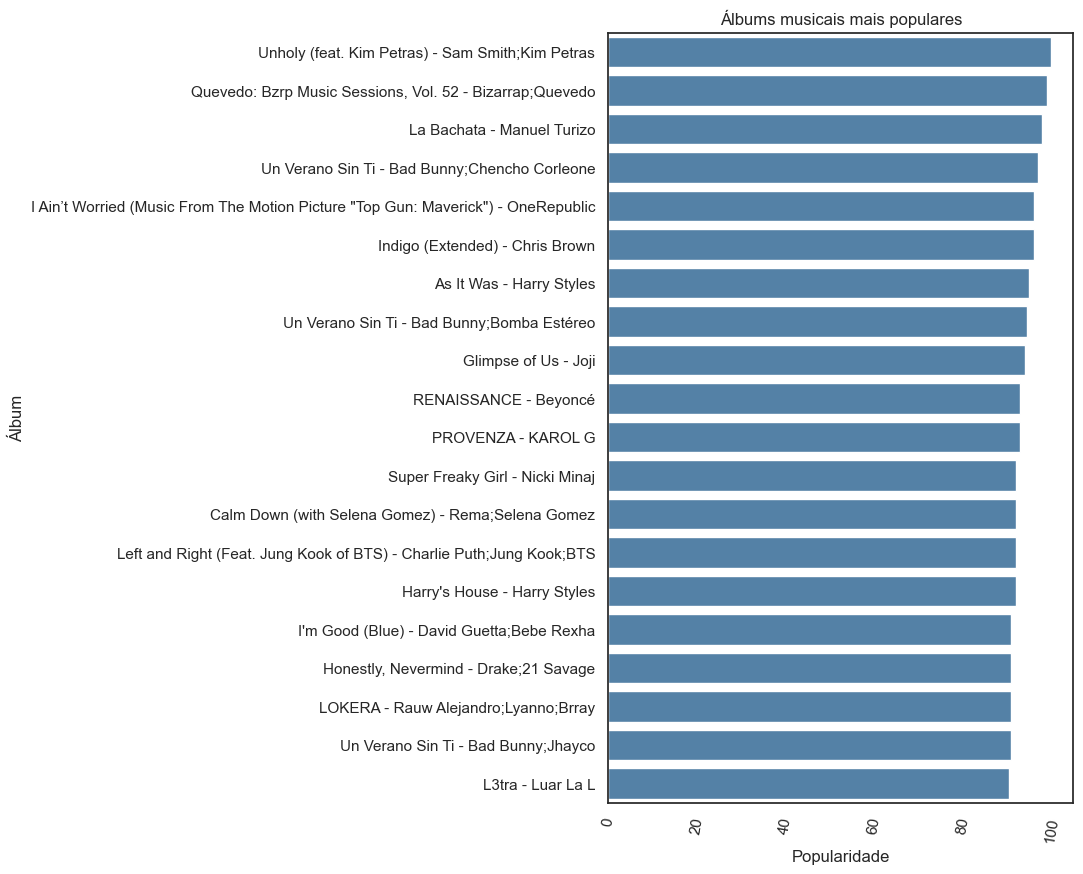

In [13]:
# most popular albums
df_top20albums = df_spotify_analise.groupby('album_name_artist')['popularity'].mean().reset_index().sort_values(by='popularity',ascending=False).head(20)

plt.figure(figsize=(6,10))
sns.barplot(data=df_top20albums,
           y = 'album_name_artist',
           x = 'popularity',
           color='steelblue').set(title='Álbums musicais mais populares')
plt.xlabel("Popularidade")
plt.ylabel("Álbum")
plt.xticks(rotation=80)
plt.show()

### Correlação

Encontramos correlação de 0.76 entre *loudness* e *energy*. É preciso avaliar a possibilidade de manter as duas variáveis no modelo, ou utilizar apenas uma delas. Por enquanto vamos manter.

<AxesSubplot: >

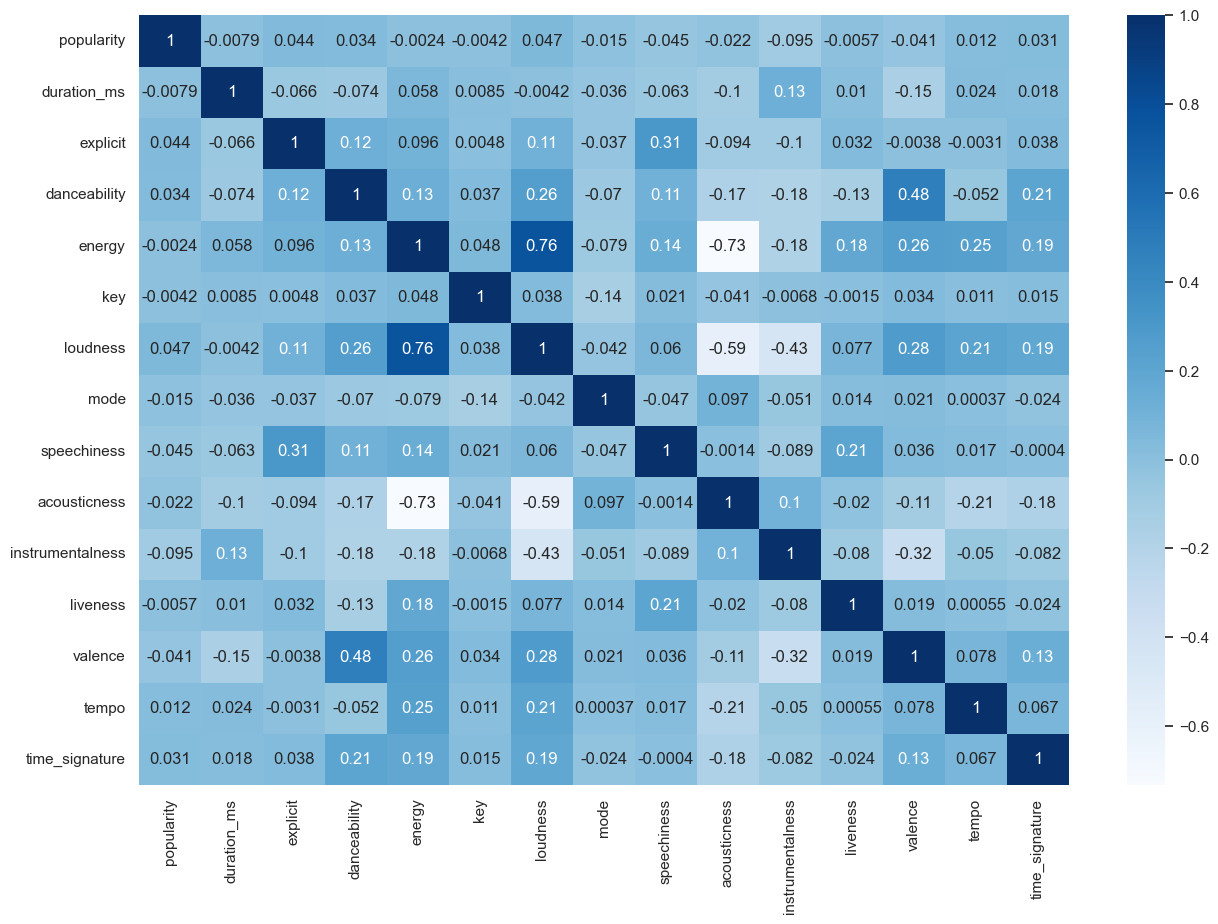

In [14]:
plt.figure(figsize=(15,10))
sns.heatmap(df_spotify.corr(numeric_only=True),annot=True, cmap='Blues')

## Pré-Processamento de Dados

Nesta etapa do projeto, vamos limpar, organizar e transformar os dados brutos em dados que possam ser usados para treinar os seus modelos.

In [15]:
# drop text columns
df_spotify = df_spotify.drop(['track_id', 'artists', 'album_name', 'track_name','track_genre','explicit'],axis=1)
print(list(df_spotify.columns))

['popularity', 'duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']


### Análise de outliers

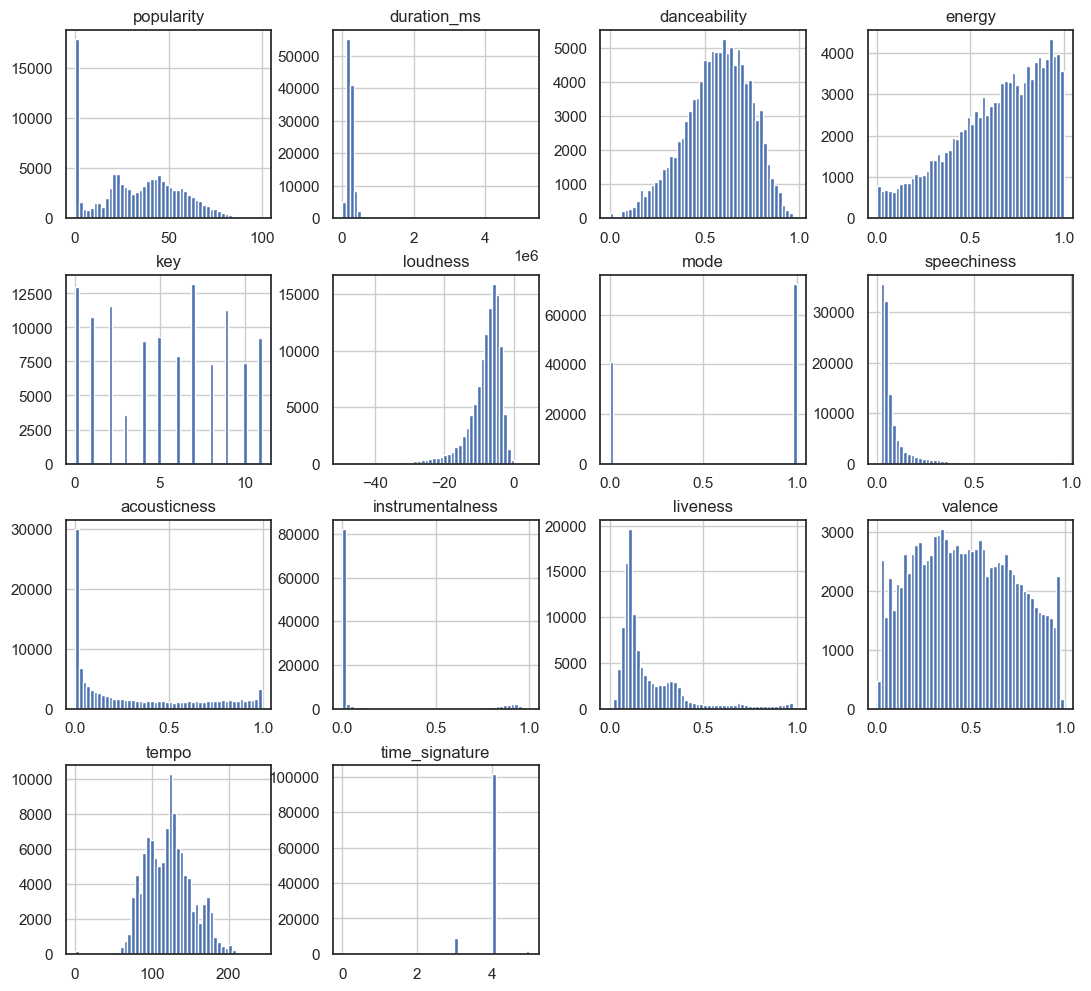

In [16]:
# plot histograms for numerical columns
df_spotify.hist(bins= 50, figsize=(13,12))
plt.show() 

In [17]:
# define function to plot multiple boxplots

def boxplot_multiple(df):
    
    # Mark outliers with red
    red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

    # Subplots of each column with its own scale
    fig, axs = plt.subplots(1, len(df.columns), figsize=(18,6))

    for i, ax in enumerate(axs.flat):
        ax.boxplot(df.iloc[:,i], flierprops=red_circle)
        ax.set_title(df.columns[i], fontsize=20, fontweight='bold')
        ax.tick_params(axis='y', labelsize=14)

    plt.tight_layout()

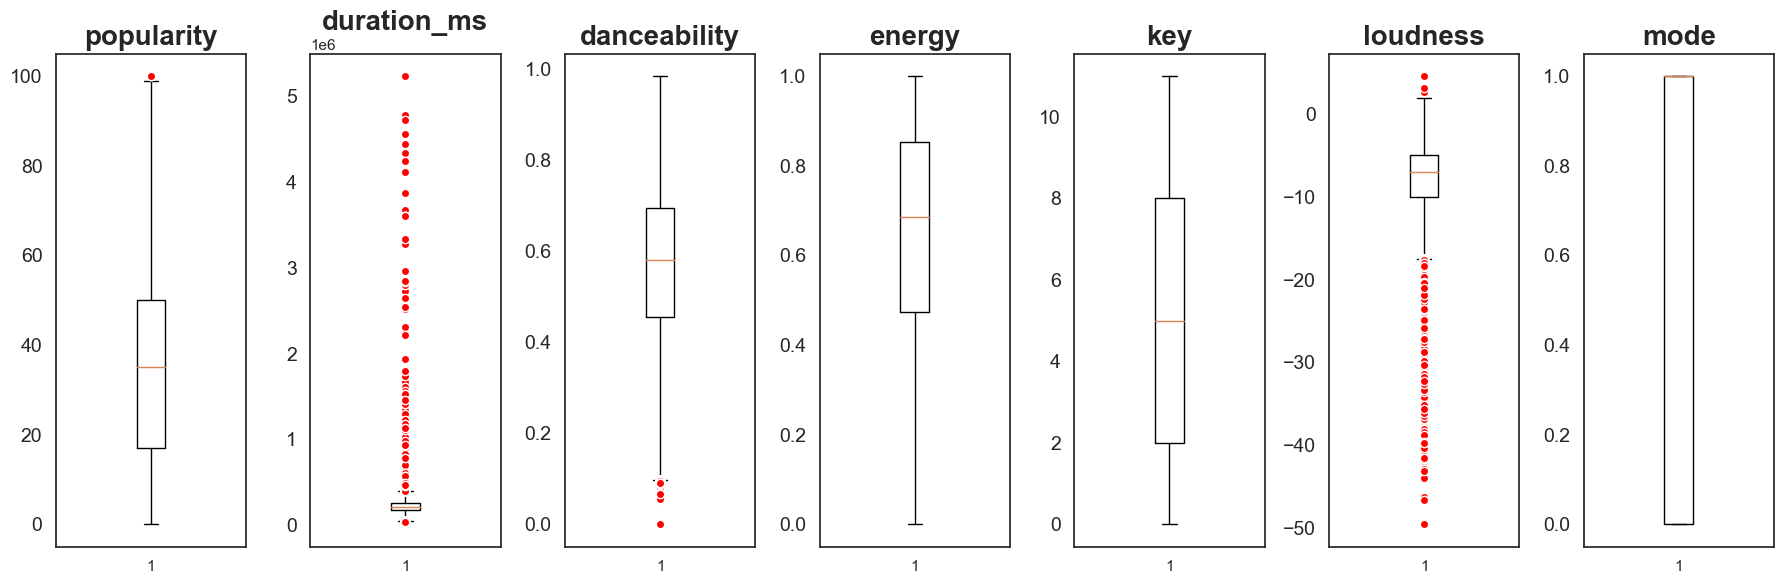

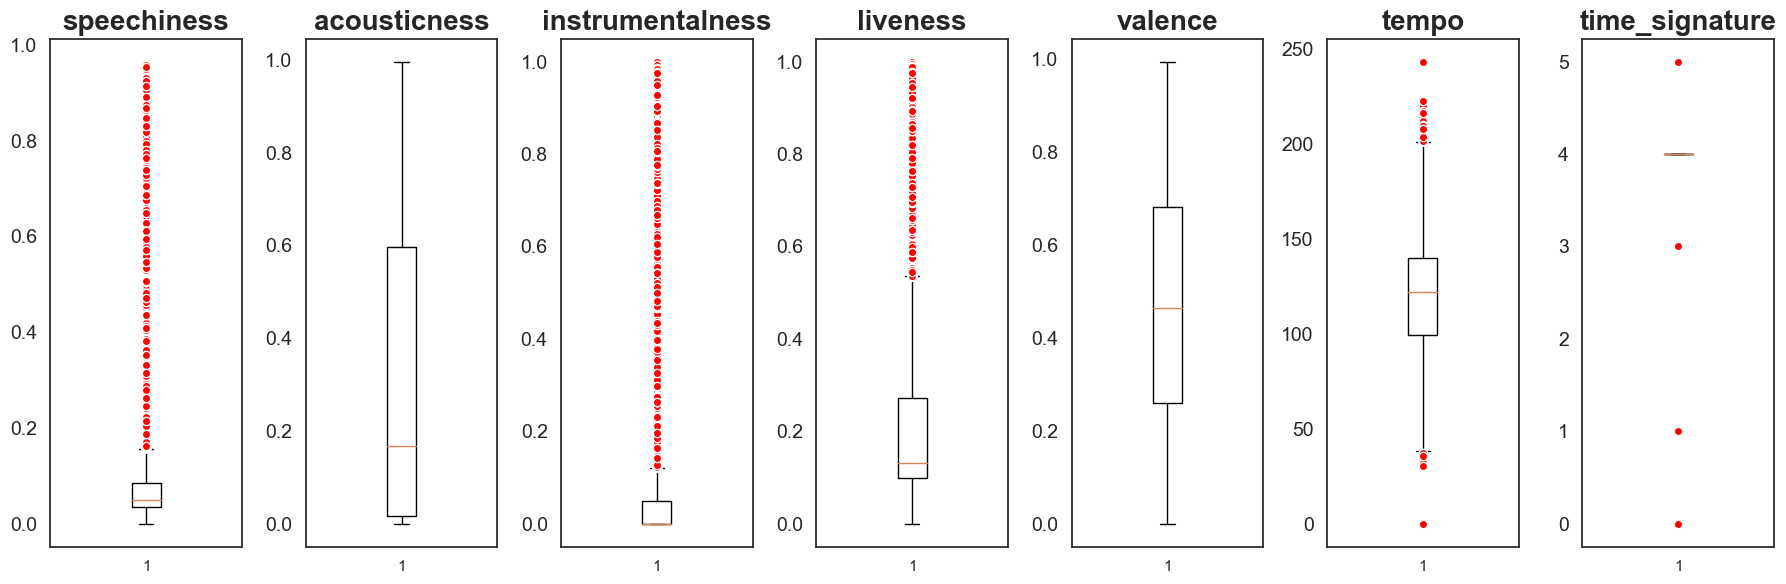

In [18]:
# plot boxplot for numerical columns
boxplot_multiple(df_spotify.iloc[:,:7])
boxplot_multiple(df_spotify.iloc[:,7:14])

### Análise minunciosa de variáveis específicas:

- duration_ms
- loudness
- speechiness
- instrumentalness
- liveness
- tempo

Para isso vamos criar funções que definem os outliers de cada variável.

#### Definindo funções

In [19]:
# upper and lower limits
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3-q1
    return q1-1.5*amplitude, q3+1.5*amplitude

# delete outliers and count deleted lines from df
def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna]>=lim_inf) & (df[nome_coluna]<=lim_sup),:]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df, linhas_removidas

# boxplot with and without limit values
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(15,5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)

# histogram
def histograma(coluna):
    plt.figure(figsize=(15,5))
    sns.histplot(coluna, kde=True, stat="density")

#### duration_ms

É a duração da música em milisegundos.

Essa variável tem muitos outliers e, para medir popularidade, as musicas novas estão cada vez mais curtas (my guess). Se o objetivo for medir popularidade de músicas futuras, então seria interessante testar o modelo retirando esses outliers. Para remover seriam 5 mil linhas. 

Por outro lado, muitas musicas acima de 6,5 minutos (limite superior para outlier) possuem alta popularidade.

Vamos manter por enquanto, mas nos ajustes do modelo escolhido remover os outliers dessa variável pode ser uma opção a se considerar.

Limites: (43078.0, 392694.0)
count    113549.00
mean     228081.37
std      106413.10
min        8586.00
25%      174184.00
50%      213000.00
75%      261588.00
max     5237295.00
Name: duration_ms, dtype: float64


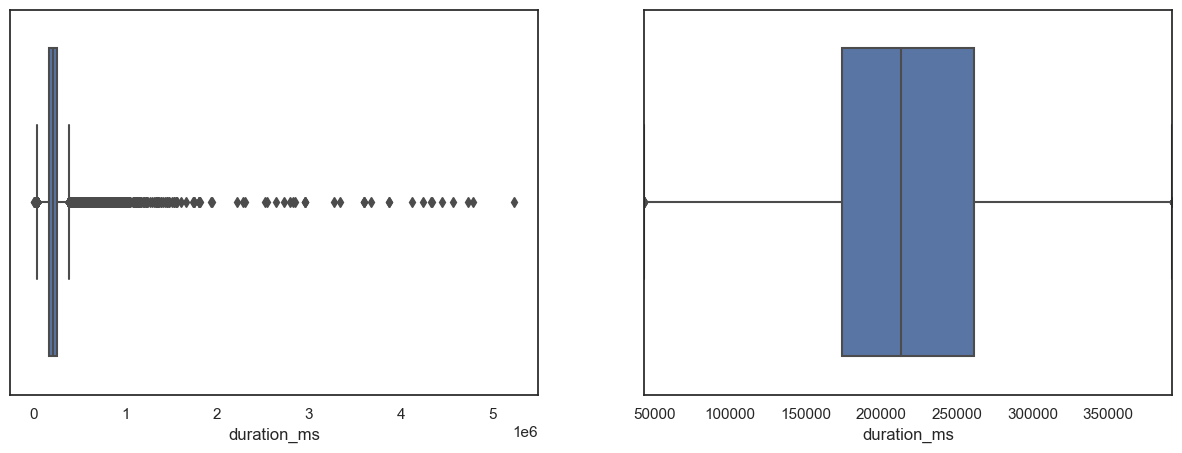

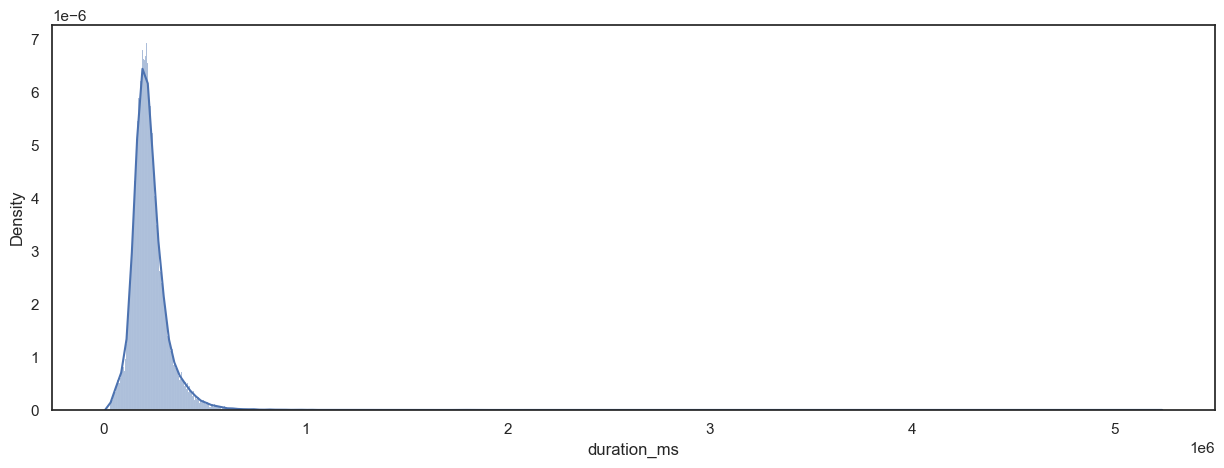

In [20]:
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

print('Limites: {}'.format(limites(df_spotify['duration_ms'])))
print(df_spotify['duration_ms'].describe())

diagrama_caixa(df_spotify['duration_ms'])
histograma(df_spotify['duration_ms'])

In [21]:
print(limites(df_spotify['duration_ms']))
print('O limite superior de 392694 ms equivale a 6,54 minutos')

#df_spotify.loc[df_spotify['duration_ms']>392694.0].sort_values(by='popularity', ascending=False).head(20)

(43078.0, 392694.0)
O limite superior de 392694 ms equivale a 6,54 minutos


#### loudness

The overall loudness of a track in decibels (dB).

A positive dB means that the sound is a few times louder than the threshold, while a negative dB means that you are a few times softer than that threshold.

Parece ok, a princípio vamos manter.

Limites: (-17.493499999999997, 2.4944999999999977)
count   113549.00
mean        -8.24
std          5.01
min        -49.53
25%        -10.00
50%         -7.00
75%         -5.00
max          4.53
Name: loudness, dtype: float64


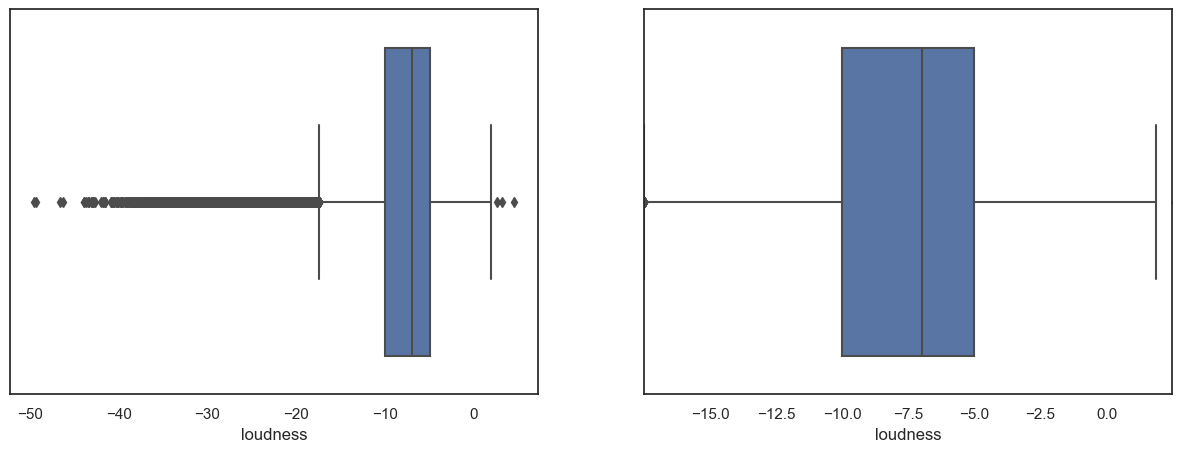

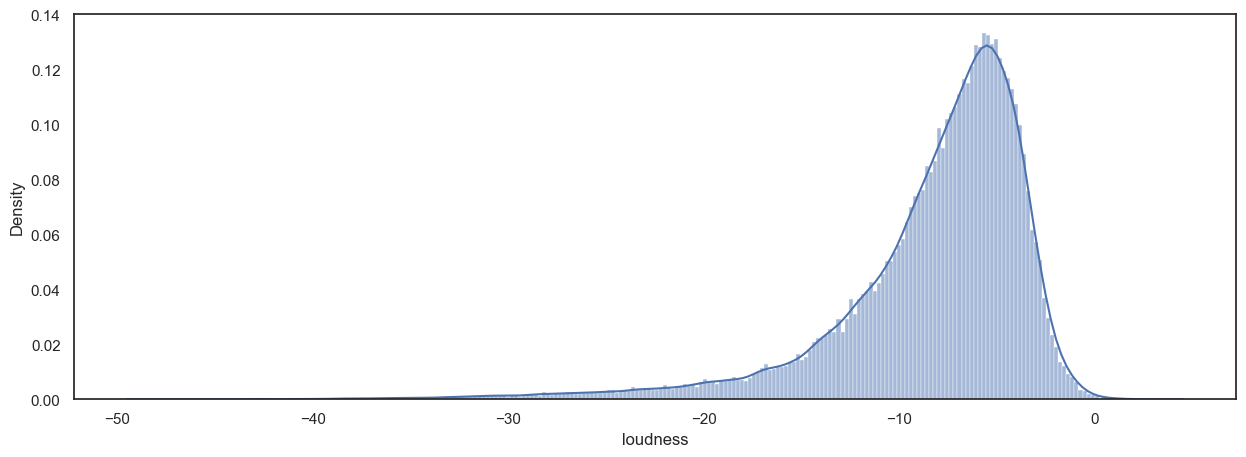

In [22]:
print('Limites: {}'.format(limites(df_spotify['loudness'])))
print(df_spotify['loudness'].describe())

diagrama_caixa(df_spotify['loudness'])
histograma(df_spotify['loudness'])

In [23]:
df_spotify.loc[df_spotify['loudness']<-17.5].head(10).sort_values(by='popularity', ascending=False)

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
3,71,201933,0.27,0.06,0,-18.52,1,0.04,0.91,0.00,0.13,0.14,181.74,3
117,60,123609,0.66,0.08,10,-19.84,1,0.04,0.91,0.00,0.16,0.57,80.00,1
16,56,129750,0.71,0.11,2,-18.10,1,0.04,0.83,0.00,0.12,0.41,110.15,4
172,55,232500,0.50,0.12,0,-17.72,1,0.05,0.85,0.00,0.17,0.34,121.19,4
17,54,169728,0.80,0.08,10,-18.09,0,0.05,0.74,0.00,0.09,0.61,91.80,4
283,51,137066,0.49,0.04,0,-21.56,1,0.04,0.95,0.00,0.12,0.15,95.07,3
116,47,112008,0.56,0.04,1,-28.28,1,0.04,0.83,0.18,0.12,0.60,125.40,4
183,44,219613,0.42,0.20,7,-18.83,1,0.05,0.93,0.49,0.08,0.16,87.25,4
270,41,196304,0.62,0.08,4,-23.66,1,0.06,0.74,0.00,0.15,0.60,90.86,4
224,40,199256,0.67,0.12,1,-17.96,1,0.04,0.88,0.00,0.14,0.34,130.01,4


#### speechiness

Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

Limites: (-0.037000000000000005, 0.1574)
count   113549.00
mean         0.08
std          0.11
min          0.00
25%          0.04
50%          0.05
75%          0.08
max          0.96
Name: speechiness, dtype: float64


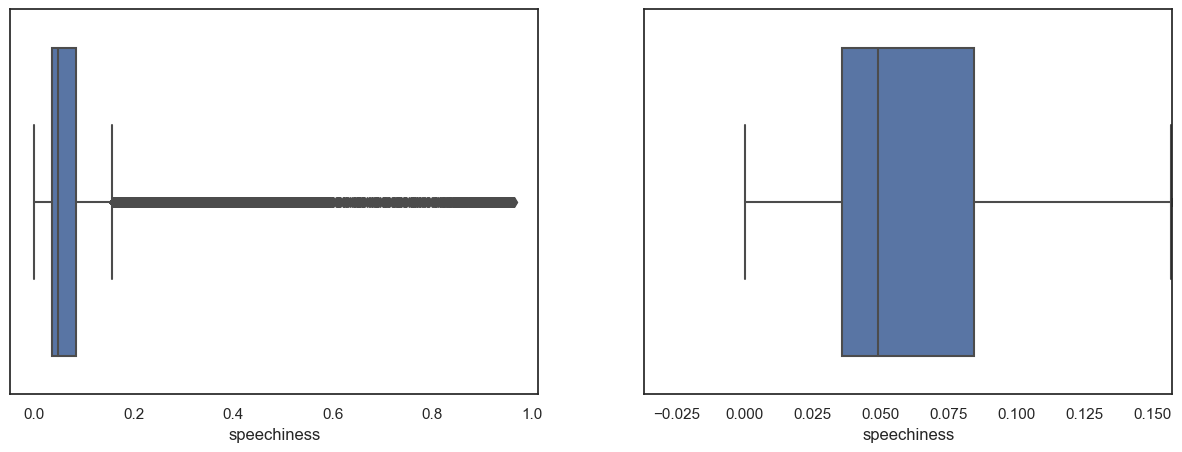

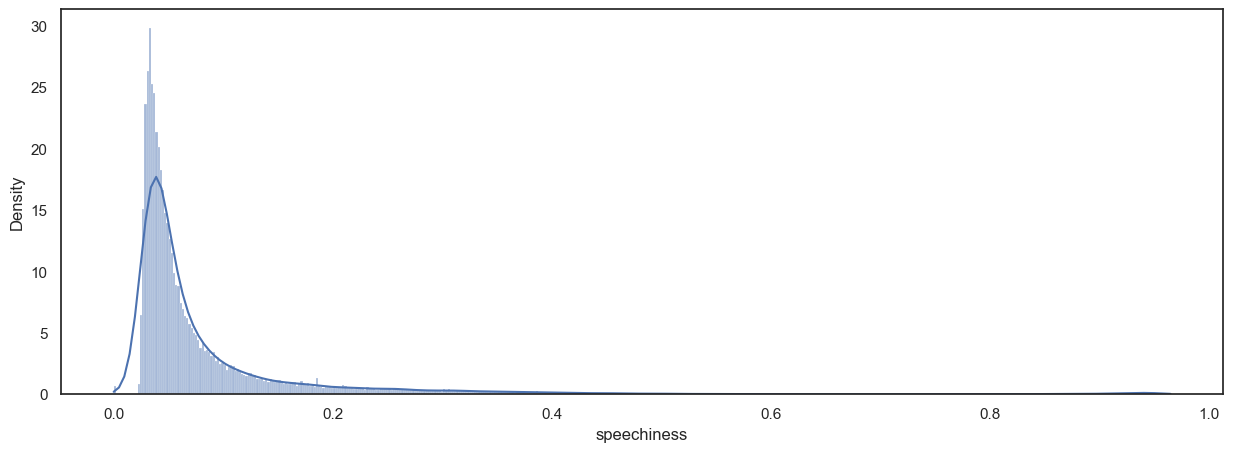

In [24]:
print('Limites: {}'.format(limites(df_spotify['speechiness'])))
print(df_spotify['speechiness'].describe())

diagrama_caixa(df_spotify['speechiness'])
histograma(df_spotify['speechiness'])

O limite superior inclui musicas como Im Yours do James Mraz... Não acho que faria sentido retirar os outliers.

Essa variável pode não ter tanto impacto na popularidade, mas inicialmente vamos manter.

In [25]:
df_spotify.loc[df_spotify['speechiness']<0.1574].head(10).sort_values(by='speechiness', ascending=False)

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,73,230666,0.68,0.46,1,-6.75,0,0.14,0.03,0.00,0.36,0.71,87.92,4
5,58,214240,0.69,0.48,6,-8.81,1,0.10,0.29,0.00,0.19,0.67,98.02,4
1,55,149610,0.42,0.17,1,-17.23,1,0.08,0.92,0.00,0.10,0.27,77.49,4
2,57,210826,0.44,0.36,0,-9.73,1,0.06,0.21,0.00,0.12,0.12,76.33,4
4,82,198853,0.62,0.44,2,-9.68,1,0.05,0.47,0.00,0.08,0.17,119.95,4
7,80,242946,0.70,0.44,11,-9.33,1,0.04,0.56,0.00,0.10,0.71,150.96,4
8,74,189613,0.62,0.41,0,-8.70,1,0.04,0.29,0.00,0.15,0.67,130.09,4
3,71,201933,0.27,0.06,0,-18.52,1,0.04,0.91,0.00,0.13,0.14,181.74,3
6,74,229400,0.41,0.15,2,-8.82,1,0.04,0.86,0.00,0.09,0.08,141.28,3
9,56,205594,0.44,0.63,1,-6.77,1,0.03,0.43,0.00,0.07,0.20,78.90,4


#### instrumentalness

Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content.

Limites: (-0.07305, 0.12175)
count   113549.00
mean         0.16
std          0.31
min          0.00
25%          0.00
50%          0.00
75%          0.05
max          1.00
Name: instrumentalness, dtype: float64


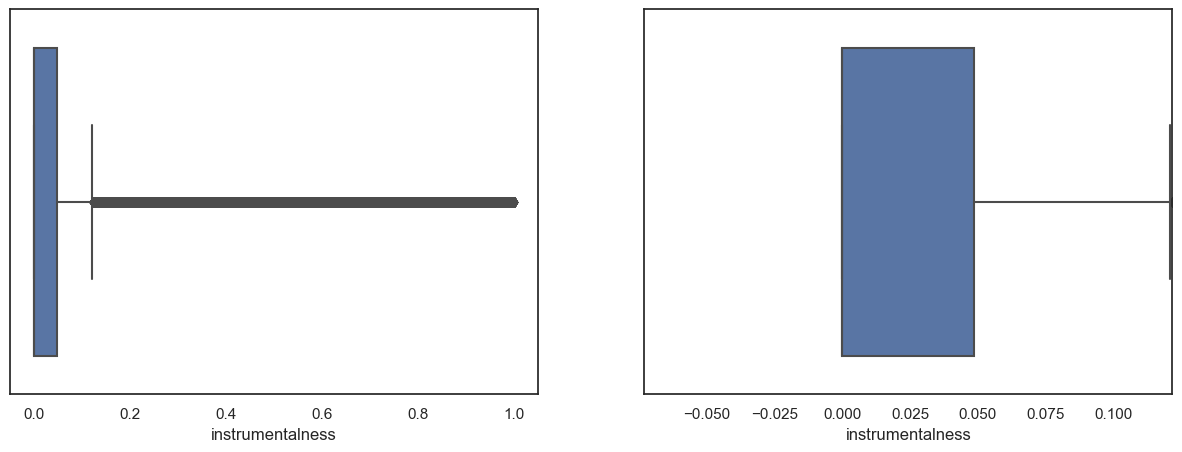

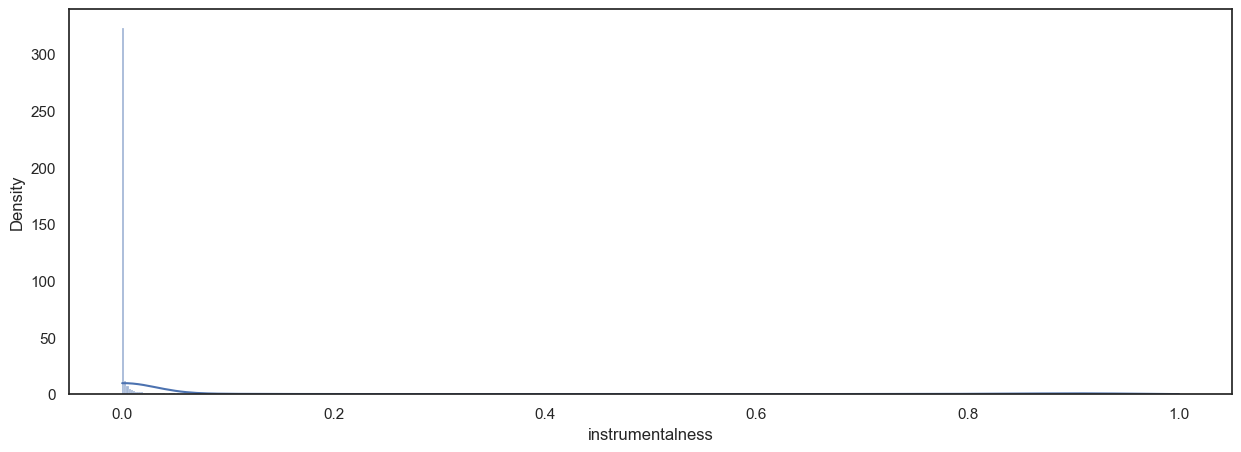

In [26]:
print('Limites: {}'.format(limites(df_spotify['instrumentalness'])))
print(df_spotify['instrumentalness'].describe())

diagrama_caixa(df_spotify['instrumentalness'])
histograma(df_spotify['instrumentalness'])

In [27]:
df_spotify.loc[df_spotify['instrumentalness']>0.12].head(10).sort_values(by='instrumentalness', ascending=False)

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
163,40,188695,0.74,0.29,6,-14.01,0,0.06,0.97,0.96,0.11,0.56,80.64,4
173,41,156787,0.77,0.14,5,-12.05,0,0.06,0.99,0.91,0.11,0.47,103.94,4
62,66,124933,0.62,0.28,1,-15.32,1,0.03,0.98,0.83,0.13,0.43,96.64,4
183,44,219613,0.42,0.20,7,-18.83,1,0.05,0.93,0.49,0.08,0.16,87.25,4
189,66,203869,0.61,0.35,4,-13.97,1,0.03,0.76,0.31,0.11,0.16,80.07,4
77,45,330933,0.54,0.34,2,-13.55,1,0.03,0.65,0.27,0.07,0.25,109.24,4
195,60,156453,0.40,0.58,7,-6.86,1,0.05,0.91,0.22,0.13,0.53,173.28,3
72,57,354400,0.54,0.57,9,-9.46,1,0.05,0.68,0.21,0.10,0.43,91.98,4
116,47,112008,0.56,0.04,1,-28.28,1,0.04,0.83,0.18,0.12,0.60,125.40,4
56,51,234473,0.53,0.33,4,-13.02,1,0.03,0.91,0.17,0.11,0.16,94.95,4


#### liveness

Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

Limites: (-0.1645, 0.5355000000000001)
count   113549.00
mean         0.21
std          0.19
min          0.00
25%          0.10
50%          0.13
75%          0.27
max          1.00
Name: liveness, dtype: float64


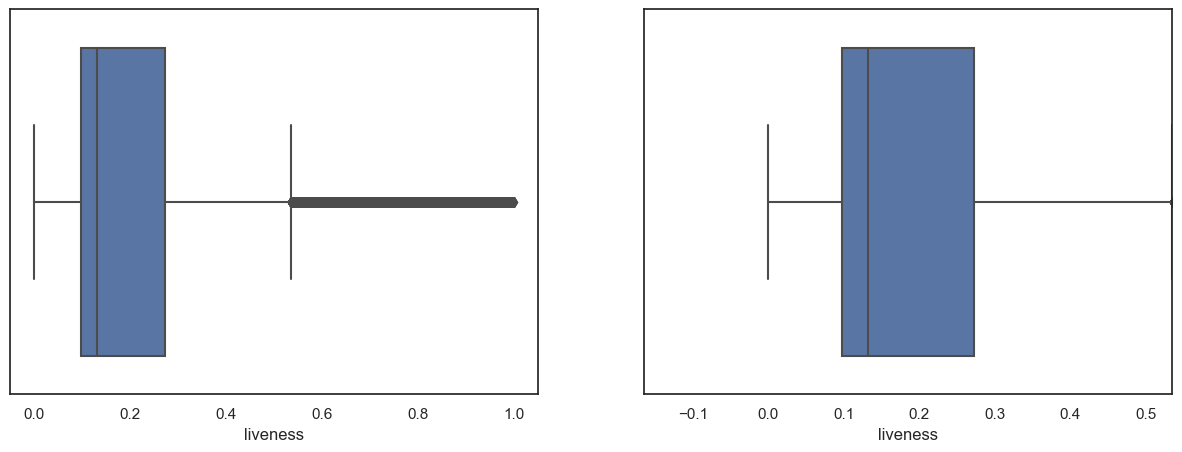

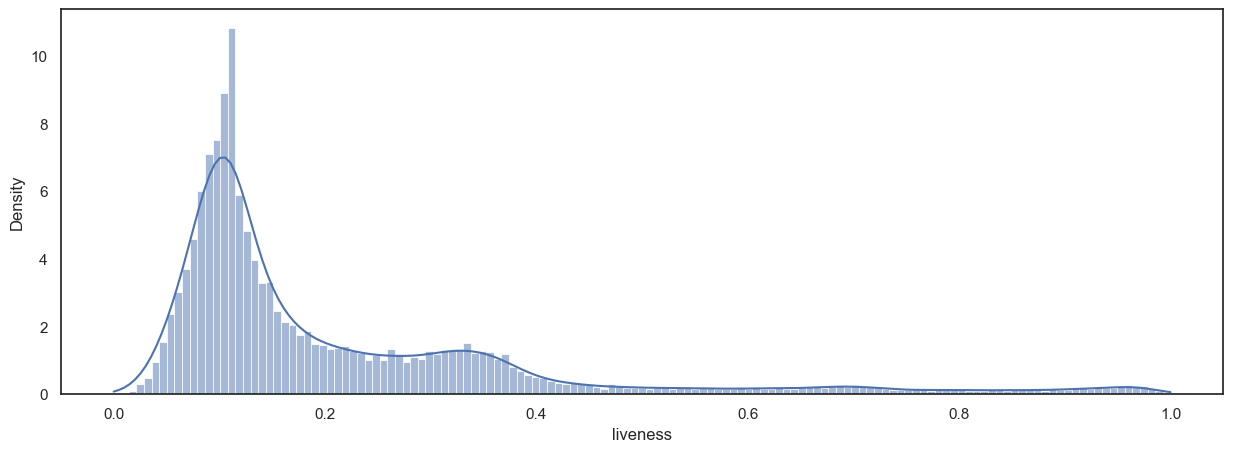

In [28]:
print('Limites: {}'.format(limites(df_spotify['liveness'])))
print(df_spotify['liveness'].describe())

diagrama_caixa(df_spotify['liveness'])
histograma(df_spotify['liveness'])

#### tempo

The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

Limites: (38.129, 201.241)
count   113549.00
mean       122.18
std         29.97
min          0.00
25%         99.30
50%        122.02
75%        140.07
max        243.37
Name: tempo, dtype: float64


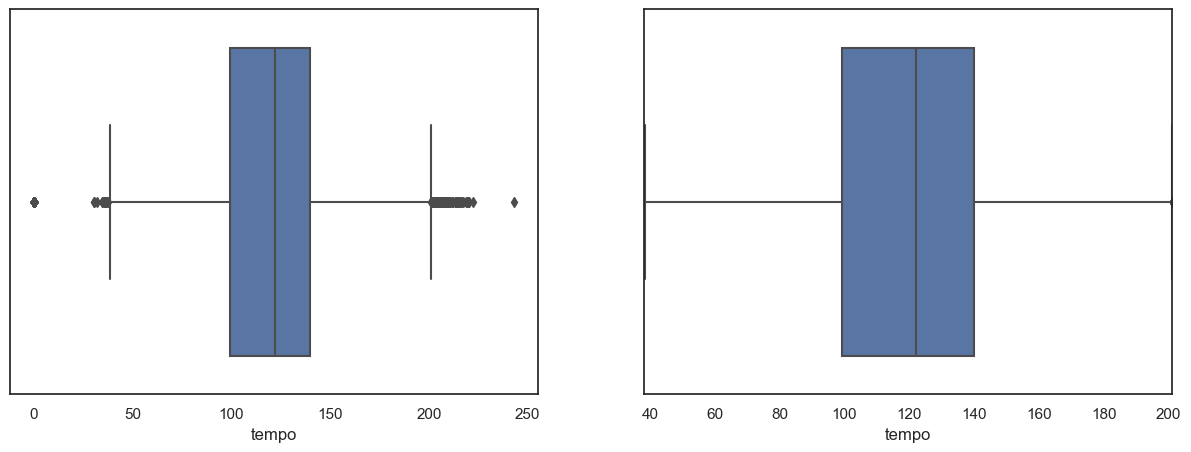

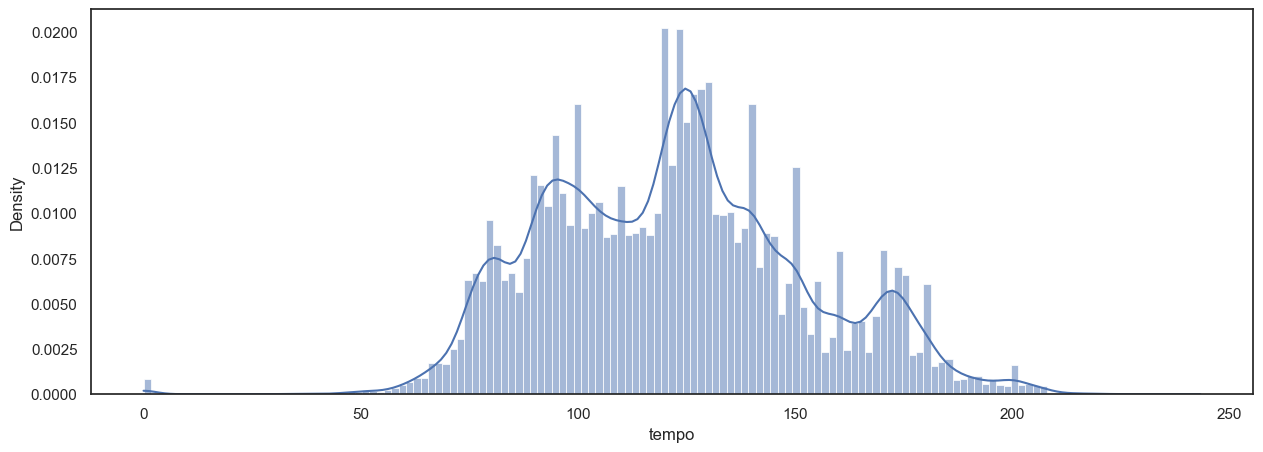

In [29]:
print('Limites: {}'.format(limites(df_spotify['tempo'])))
print(df_spotify['tempo'].describe())

diagrama_caixa(df_spotify['tempo'])
histograma(df_spotify['tempo'])

Para o primeiro modelo, decidimos não retirar nenhum outlier. Mas para refinamentos podemos revisitar essa análise.

### Encoding

A coluna de popularidade apresenta números que variam de 0 a 100. E de acordo com a documentação da API do Spotify, 100 representa a mais popular. Esse número é baseado no número total de reproduções que a faixa teve e quão recentes são as reproduções.

Como queremos saber se uma música será popular ou não, é preciso estabelecer um corte de popularidade. Vamos definir que músicas com popularidade acima de 80 são consideradas populares e aquelas abaixo de 80 são consideradas não populares.

Por isso, vamos converter a coluna de popularidade em uma classe binária (1 para popular, 0 para não popular).

In [30]:
# popularity cut in 80
df_spotify_cod = df_spotify.copy()
df_spotify_cod['popularity'] = np.where(df_spotify['popularity']>=80,1,0)
print(df_spotify_cod['popularity'].value_counts())

0    112350
1      1199
Name: popularity, dtype: int64


Além disso, vamos normalizar os dados. Essa etapa é necessária para a aplicação de alguns modelos, como a Regressão Logística.

In [31]:
# normalizing the data
df_spotify_cod=(df_spotify_cod-df_spotify_cod.min())/(df_spotify_cod.max()-df_spotify_cod.min())
print(df_spotify_cod.shape)
display(df_spotify_cod.head()) 

(113549, 14)


,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,0.00,0.04,0.69,0.46,0.09,0.79,0.00,0.15,0.03,0.00,0.36,0.72,0.36,0.80
1,0.00,0.03,0.43,0.17,0.09,0.60,1.00,0.08,0.93,0.00,0.10,0.27,0.32,0.80
2,0.00,0.04,0.44,0.36,0.00,0.74,1.00,0.06,0.21,0.00,0.12,0.12,0.31,0.80
3,0.00,0.04,0.27,0.06,0.00,0.57,1.00,0.04,0.91,0.00,0.13,0.14,0.75,0.60
4,1.00,0.04,0.63,0.44,0.18,0.74,1.00,0.05,0.47,0.00,0.08,0.17,0.49,0.80


In [32]:
# final variable type check
df_spotify_cod['popularity'] = df_spotify_cod['popularity'].astype(int)
df_spotify_cod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113549 entries, 0 to 113999
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   popularity        113549 non-null  int32  
 1   duration_ms       113549 non-null  float64
 2   danceability      113549 non-null  float64
 3   energy            113549 non-null  float64
 4   key               113549 non-null  float64
 5   loudness          113549 non-null  float64
 6   mode              113549 non-null  float64
 7   speechiness       113549 non-null  float64
 8   acousticness      113549 non-null  float64
 9   instrumentalness  113549 non-null  float64
 10  liveness          113549 non-null  float64
 11  valence           113549 non-null  float64
 12  tempo             113549 non-null  float64
 13  time_signature    113549 non-null  float64
dtypes: float64(13), int32(1)
memory usage: 12.6 MB


## Modelagem

### Divisão dos dados

Os dados serão divididos entre treino, validação e teste.

In [33]:
# split data between training and test (20%)
df_train, df_test = train_test_split(df_spotify_cod, test_size=0.2, random_state=42, shuffle=True)
print(df_train.shape)
print(df_test.shape)
print(f'Proporção de dados de teste no total: {round(df_test.shape[0]/df_spotify_cod.shape[0],4)}')
print(f'Proporção de dados de treino no total: {round(df_train.shape[0]/df_spotify_cod.shape[0],4)}')

(90839, 14)
(22710, 14)
Proporção de dados de teste no total: 0.2
Proporção de dados de treino no total: 0.8


In [34]:
# proportions of the target variable
print(df_train.popularity.value_counts(normalize=True))
print('-'*30)
print(df_test.popularity.value_counts(normalize=True))

0   0.99
1   0.01
Name: popularity, dtype: float64
------------------------------
0   0.99
1   0.01
Name: popularity, dtype: float64


In [35]:
# split train data between X and y
X = df_train.drop('popularity', axis=1)
y = df_train.popularity

Para a divisão entre dados de treino e de validação usaremos a função **StratifiedKFold** porque, diferentemente de outras funções (como train_test_split ou KFold) ela preserva a distribuição de classes presentes nos dados. No nosso caso, há distribuição maior de popularidade<80.

Sempre que a proporção de classes da base de dados utilizada para a modelagem dor desbaanceada, é preferível utilizar a função StratifiedKFold para dividir os dados entre treino e validação [mais informações neste artigo.](https://towardsdatascience.com/how-to-train-test-split-kfold-vs-stratifiedkfold-281767b93869)

In [36]:
# split data between train and validation while preserving samples proportions
StratifKfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in StratifKfold.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

In [37]:
# check popularity proportions
print(f'Dimensões: {X_train.shape, X_val.shape, y_train.shape, y_val.shape}\n')
print(f"Proporção de df_train para classe=1: {round(len(df_train[df_train.popularity==1]) / df_train.shape[0], 4)}\n")
print(f"Proporção de X_train para classe=1:  {round(len(y_train[y_train==1]) / X_train.shape[0], 4)}")
print(f"Proporção de X_val para classe=1:    {round(len(y_val[y_val==1]) / X_val.shape[0], 4)}")

Dimensões: ((72672, 13), (18167, 13), (72672,), (18167,))

Proporção de df_train para classe=1: 0.0106

Proporção de X_train para classe=1:  0.0106
Proporção de X_val para classe=1:    0.0106


### Modelo Baseline

O baseline é um modelo inicial muito básico, que servirá como uma linha de base para a comparação com outros modelos e soluções mais complexas. Serve para estabelecer uma comparação: queremos que os modelos mais complexos obtenham melhor pontuação que a baseline.

A Regressão Logística é frequentemente usada como um modelo de baseline em problemas de classificação, por ser um modelo simples e fácil de interpretar. Ela estima probabilidades usando uma função logística.

In [38]:
# cretae
model_lr = LogisticRegression()

# train
model_lr.fit(X_train, y_train)

# predict with validation data
pred_baseline = model_lr.predict(X_val)

In [39]:
# show coefficients
df_coef = df_spotify_cod.drop(columns='popularity')
coef_baseline = model_lr.coef_.tolist()[0]

data = {"Features": df_coef.columns,
        "Coef_lr": coef_baseline}

data = pd.DataFrame(data)
display(data)

,Features,Coef_lr
0,duration_ms,-1.17
1,danceability,2.18
2,energy,-1.45
3,key,0.03
4,loudness,4.67
5,mode,-0.08
6,speechiness,-0.39
7,acousticness,-1.76
8,instrumentalness,-2.67
9,liveness,-1.56


### Validando o Baseline

A avaliação de um modelo de classificação é feita a partir da comparação entre as classes preditas pelo modelo e as classes verdadeiras de cada exemplo. Todas as métricas tem o objetivo de medir quão distante o modelo está de uma classificação perfeita, porém, fazem isto de formas diferentes.
Uma forma simples de visualizar a performance de um modelo é através da matriz de confusão.

#### Matriz de confusão

- Esqurdo superior: verdadeiro positivo (a música é popular e modelo acertou)
- Direito inferior: verdadeiro negativo (a música não é popular e o modelo acertou)
- Direito superior: falso negativo (o modelo diz que é popular, mas o valor real é não popular)
- Esquerdo inferior: falso positivo (o modelo diz que não é popular, mas o valor real é popular)

In [40]:
# confusion matrix
print(f'Logistic Regression (Baseline):')
print(confusion_matrix(y_val, pred_baseline.round()))

Logistic Regression (Baseline):
[[17975     0]
 [  192     0]]


#### Métricas de avaliação:

- Acurácia: mostra, dentre todas as classificações, quantas o modelo classificou corretamente;
- Precisão: indica, dentre todas as classificações de classe Popular que o modelo fez, quantas estão corretas;
- Recall: mostra, dentre todas as situações de classe Popular como valor esperado, quais estão corretas;
- F1-score: é a média harmônica entre precisão e recall.

A escolha da métrica dependerá do objetivo do projeto e das características do conjunto de dados. 
- Se o objetivo for minimizar os falsos positivos, a precisão será a métrica mais importante. 
- Se o objetivo for minimizar os falsos negativos, o recall será a métrica mais importante.

In [41]:
print(f'Modelo:   Logistic Regression (Baseline)')
print(f'Accuracy: {accuracy_score(y_val, pred_baseline.round())}')
print(f'Precision: {precision_score(y_val, pred_baseline.round(),zero_division=0)}')
print(f'Recall: {recall_score(y_val, pred_baseline.round())}')
print(f'F1: {f1_score(y_val, pred_baseline.round())}')

Modelo:   Logistic Regression (Baseline)
Accuracy: 0.9894313865800628
Precision: 0.0
Recall: 0.0
F1: 0.0


### Reamostragem e comparação com outros modelos

Para comparar o desempenho do baseline, escolhemos os seguintes modelos de classificação:

In [42]:
modelo_lr = LogisticRegression()
modelo_dt = DecisionTreeClassifier()
modelo_rf = RandomForestClassifier()
modelo_kn = KNeighborsClassifier()

modelos = {'LogisticRegression': modelo_lr,
           'DecisionTree': modelo_dt,
           'RandomForest': modelo_rf,
           'KNearest': modelo_kn
          }

No entanto, antes de estimar os novos modelos, precisamos ajustar a questão do **desbalanceamento de classes** nos dados do modelo. Isso porque definimos a variável a ser estimada - popularity - com o seguinte corte:

- se popularity é maior ou igual a 80, então a música é popular (classe 0)
- se popularity é menor que 80, então a música não é popular (classe 1)

Isso gera um desbalanceamento de classes, de modo que existem muitas músicas na classe 0 e poucas músicas na classe 1. Quando há essa característica nos dados, é possível que um modelo alcance uma acurácia alta prevendo que todas observações serão da classe majoritária. Esse é um problema conhecido como **paradoxo da acurácia** - isto é, em caso de dados desbalanceados, uma alta acurácia pode não garantir uma boa performance do modelo.

> "There are two common approaches to tackle the problem of extremely imbalanced data. One is based on cost sensitive learning: assigning a high cost to misclassification of the minority class, and trying to minimize the overall cost. Domingos (1999) and Pazzani et al. (1994) are among these. The other approach is to use a sampling technique: Either down-sampling the majority class or over-sampling the minority class, or both." (Chen & Breiman, 2004).

> Complete article: [Using Random Forest to Learn Imbalanced Data](https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf)

Existem algumas estratégias para lidar com esse problema. Neste projeto, vamos adotar **duas técnicas de redistribuição dos dados**:

- Distribuição **Random Over-Sampling**: são criadas novas observações da classe minoritária
- Distribuição **Random Under-Sampling**: são reduzidas as observações da classe majoritária

### Distribuição Random Over-Sampling

In [43]:
# instantiate method
oversample = RandomOverSampler(sampling_strategy='minority')

# transform data
X_over, y_over = oversample.fit_resample(X_train, y_train)

# new class distribution
counter = Counter(y_over)
print(counter)

Counter({0: 71902, 1: 71902})


In [44]:
# train models
for nome_modelo, modelo in modelos.items():
    modelo.fit(X_over, y_over)

In [45]:
# coeficients
df_coef = df_spotify_cod.drop(columns='popularity')

coef_modelos = {
    "Features": df_coef.columns,
    "Coef_lr": modelo_lr.coef_.tolist()[0],
    "Coef_dt": modelo_dt.feature_importances_,
    "Coef_rf": modelo_rf.feature_importances_,
    "Coef_et": '-'
}

coef_modelos = pd.DataFrame(coef_modelos)
coef_modelos

,Features,Coef_lr,Coef_dt,Coef_rf,Coef_et
0,duration_ms,-10.44,0.10,0.09,-
1,danceability,1.75,0.07,0.09,-
2,energy,-2.34,0.12,0.11,-
3,key,0.09,0.03,0.04,-
4,loudness,7.93,0.10,0.12,-
5,mode,-0.07,0.01,0.01,-
6,speechiness,-0.28,0.08,0.08,-
7,acousticness,-2.00,0.12,0.11,-
8,instrumentalness,-2.47,0.11,0.10,-
9,liveness,-2.00,0.08,0.09,-


In [46]:
# confusion_matrix
for nome_modelo, modelo in modelos.items():
    # validate
    previsao = modelo.predict(X_val)
    print(f'Modelo {nome_modelo}:')
    print(confusion_matrix(y_val, previsao.round()))

Modelo LogisticRegression:
[[11061  6914]
 [   50   142]]
Modelo DecisionTree:
[[17755   220]
 [   72   120]]
Modelo RandomForest:
[[17834   141]
 [   73   119]]
Modelo KNearest:
[[17678   297]
 [   78   114]]


In [47]:
def avaliar_modelo(nome_modelo, y_validacao, previsao): 
    accuracy = accuracy_score(y_validacao, previsao.round())
    precision = precision_score(y_validacao, previsao.round(),zero_division=0)
    recall = recall_score(y_validacao, previsao.round())
    f1 = f1_score(y_validacao, previsao.round())
    
    print('Modelo: {}'.format(nome_modelo))
    print('Accuracy: {}'.format(accuracy))
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1: {}'.format(f1))
    return print('-'*20)

In [48]:
print('Validando modelos: dados de validação\n')

for nome_modelo, modelo in modelos.items():
    # validate
    previsao = modelo.predict(X_val)
    avaliar_modelo(nome_modelo, y_val, previsao)

Validando modelos: dados de validação

Modelo: LogisticRegression
Accuracy: 0.6166675840810261
Precision: 0.020124716553287982
Recall: 0.7395833333333334
F1: 0.039183222958057394
--------------------
Modelo: DecisionTree
Accuracy: 0.9839269004238455
Precision: 0.35294117647058826
Recall: 0.625
F1: 0.4511278195488722
--------------------
Modelo: RandomForest
Accuracy: 0.988220399625695
Precision: 0.4576923076923077
Recall: 0.6197916666666666
F1: 0.5265486725663716
--------------------
Modelo: KNearest
Accuracy: 0.979358176914185
Precision: 0.2773722627737226
Recall: 0.59375
F1: 0.37810945273631835
--------------------


### Distribuição Random Under-Sampling

In [49]:
# instantiate method
undersample = NearMiss()

# transform data
X_under, y_under = undersample.fit_resample(X_train, y_train)

# print new class distribution
counter = Counter(y_under)
print(counter)

Counter({0: 770, 1: 770})


In [50]:
# train models
for nome_modelo, modelo in modelos.items():
    modelo.fit(X_under, y_under)

In [51]:
# coeficientes
df_coef = df_spotify_cod.drop(columns='popularity')

coef_modelos = {
    "Features": df_coef.columns,
    "Coef_lr": modelo_lr.coef_.tolist()[0],
    "Coef_dt": modelo_dt.feature_importances_,
    "Coef_rf": modelo_rf.feature_importances_,
    "Coef_et": '-'
}

coef_modelos = pd.DataFrame(coef_modelos)
coef_modelos

,Features,Coef_lr,Coef_dt,Coef_rf,Coef_et
0,duration_ms,0.01,0.02,0.06,-
1,danceability,-2.74,0.12,0.09,-
2,energy,-1.94,0.09,0.11,-
3,key,-0.69,0.05,0.05,-
4,loudness,-0.55,0.05,0.10,-
5,mode,-0.25,0.01,0.01,-
6,speechiness,0.32,0.07,0.11,-
7,acousticness,1.88,0.19,0.13,-
8,instrumentalness,2.26,0.08,0.07,-
9,liveness,2.23,0.11,0.08,-


In [52]:
# confusion_matrix
for nome_modelo, modelo in modelos.items():
    # validate
    previsao = modelo.predict(X_val)
    print(f'Modelo {nome_modelo}:')
    print(confusion_matrix(y_val, previsao.round()))

Modelo LogisticRegression:
[[ 3832 14143]
 [   73   119]]
Modelo DecisionTree:
[[ 2777 15198]
 [   22   170]]
Modelo RandomForest:
[[  403 17572]
 [    6   186]]
Modelo KNearest:
[[ 3080 14895]
 [   50   142]]


In [53]:
print('Validando modelos: dados de validação\n')

for nome_modelo, modelo in modelos.items():
    # validate
    previsao = modelo.predict(X_val)
    avaliar_modelo(nome_modelo, y_val, previsao)

Validando modelos: dados de validação

Modelo: LogisticRegression
Accuracy: 0.2174822480321462
Precision: 0.008343850792315243
Recall: 0.6197916666666666
F1: 0.016466030164660302
--------------------
Modelo: DecisionTree
Accuracy: 0.16221720702372433
Precision: 0.011061946902654867
Recall: 0.8854166666666666
F1: 0.021850899742930592
--------------------
Modelo: RandomForest
Accuracy: 0.032421423460119995
Precision: 0.010474152494650299
Recall: 0.96875
F1: 0.02072423398328691
--------------------
Modelo: KNearest
Accuracy: 0.17735454395332195
Precision: 0.009443373013234023
Recall: 0.7395833333333334
F1: 0.018648630901569374
--------------------


## Modelo selecionado e ajustes

No geral, o modelo **Random Forest** com a redistribuição **Random Over-Sampling** apresentou melhor desempenho nos dados de validação. Vamos ajustar a sua modelagem definindo hiperparâmetros e realizando validação cruzada.

#### Definir hiperparâmetros

In [54]:
# number of trees in random forest
n_estimators = [3,5,10,100]

# number of features to consider at every split
max_features = [3,4,5,6,None]

# maximum number of levels in tree
max_depth = [3,4,5,6,None]

# wheigt for each class
class_weight = ['balanced',None]

# method of selecting samples for training each tree
bootstrap = [True, False]

# create random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'class_weight': class_weight,
               'bootstrap': bootstrap}

# parameters
random_grid

{'n_estimators': [3, 5, 10, 100],
 'max_features': [3, 4, 5, 6, None],
 'max_depth': [3, 4, 5, 6, None],
 'class_weight': ['balanced', None],
 'bootstrap': [True, False]}

#### Definir hiperparâmetros com RandomizedSearchCV

In [55]:
# transform data in arrays
X_train_array = X_train.values
X_val_array = X_val.values
y_train_array = y_train.values
y_val_array = y_val.values

In [56]:
# instanciate RandomizedSearchCV with parameter grid
random_search = RandomizedSearchCV(estimator = RandomForestClassifier(),
                                   param_distributions = random_grid,
                                   random_state=42)

# set empty lists to store cross-validation results 
accuracy_lst_rf = []
precision_lst_rf = []
recall_lst_rf = []
f1_lst_rf = []
auc_lst_rf = []

# loop for cross validation
for train, test in StratifKfold.split(X_train_array, y_train_array):
    
    # pipeline with RandomOverSampler
    pipeline_rf = imbalanced_make_pipeline(RandomOverSampler(sampling_strategy='minority'), random_search)
    
    # apply RandomizedSearchCV
    model_rf = pipeline_rf.fit(X_train_array[train], y_train_array[train])

    # chosen model
    best_est_rf = random_search.best_estimator_
    
    # prediction
    prediction_rf = best_est_rf.predict(X_train_array[test])
    
    # validation results
    accuracy_lst_rf.append(model_rf.score(X_train_array[test], y_train_array[test]))
    precision_lst_rf.append(precision_score(y_train_array[test], prediction_rf))
    recall_lst_rf.append(recall_score(y_train_array[test], prediction_rf))
    f1_lst_rf.append(f1_score(y_train_array[test], prediction_rf))
    auc_lst_rf.append(roc_auc_score(y_train_array[test], prediction_rf))

In [57]:
# best parameters
print(f"melhores estimadores para RF: {random_search.best_params_}")

# print cross-validation results
print('---' * 20)
print('Resultados')
print(f"accuracy:  {np.mean(accuracy_lst_rf)}")
print(f"precision: {np.mean(precision_lst_rf)}")
print(f"recall:    {np.mean(recall_lst_rf)}")
print(f"f1:        {np.mean(f1_lst_rf)}")
print(f"AUC:       {np.mean(auc_lst_rf)}")
print('---' * 20)

melhores estimadores para RF: {'n_estimators': 10, 'max_features': 6, 'max_depth': None, 'class_weight': 'balanced', 'bootstrap': True}
------------------------------------------------------------
Resultados
accuracy:  0.9876568722361464
precision: 0.43398292105953445
recall:    0.5415584415584416
f1:        0.4815394771935234
AUC:       0.7669962937232682
------------------------------------------------------------


In [58]:
pd.DataFrame(prediction_rf).value_counts() 

# modelo nao classifica todos como 0 popularidade
# pois foi feito ajuste do desbalanceamento de classes com Random Over-Sampling

0    14331
1      203
dtype: int64

Note que o modelo final nao classifica todos como não-populares, justamente porque foi feito ajuste no desbalanceamento de classes com Random Over-Sampling

Pelo resultado das métricas de avaliação, escolhemos este como o modelo final.

## Modelo Final

Por fim, vamos treinar o modelo com a totalidade dos dados de treino.

Em seguida, vamos realizar a previsão com os dados de teste.

### Treinar modelo Final

In [59]:
# split data
X = df_spotify_cod.drop('popularity', axis=1)
y = df_spotify_cod.popularity

# define model with hiperparameter tuning
final_model = random_search.best_estimator_

# define pipeline
pipeline = imbalanced_make_pipeline(RandomOverSampler(sampling_strategy='minority'), final_model)

# train model
model = pipeline.fit(X, y)
model[1]

RandomForestClassifier(class_weight='balanced', max_features=6, n_estimators=10)

In [60]:
# coefficients
df_coef = df_spotify_cod.drop(columns='popularity')
coef_baseline = model.steps[1][1].feature_importances_

data = {"Features": df_coef.columns,
        "Coef_lr": coef_baseline}

data = pd.DataFrame(data).sort_values('Coef_lr', ascending=False)
display(data)

,Features,Coef_lr
2,energy,0.13
4,loudness,0.12
8,instrumentalness,0.11
7,acousticness,0.10
1,danceability,0.09
0,duration_ms,0.09
10,valence,0.09
6,speechiness,0.08
11,tempo,0.08
9,liveness,0.08


### Previsão com modelo Final

In [61]:
# spliting test data
X_test = df_test.drop('popularity', axis=1)
y_test = df_test.popularity

# predict
y_pred_test = model.predict(X_test)

In [62]:
# confusion matrix
print(f'Final Model:')
print(confusion_matrix(y_test, y_pred_test.round()))

Final Model:
[[22255   218]
 [    0   237]]


In [63]:
# print results
print(f"accuracy:  {accuracy_score(y_test, y_pred_test)}")
print(f"precision: {precision_score(y_test, y_pred_test)}")
print(f"recall:    {recall_score(y_test, y_pred_test)}")
print(f"f1:        {f1_score(y_test, y_pred_test)}")

accuracy:  0.9904007045354469
precision: 0.5208791208791209
recall:    1.0
f1:        0.6849710982658961
